# Full-Learning MNIST PC Network
Purpose: To see if we can learn not only (v)<->(e) connections, but also the (e)<->(v) connections. Those connections have previously been set to 1:1 identity mappings. But here they start as random connection weights, and learn using the same update rule as the other learning connections.

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import  datasets, transforms
from IPython.display import display
from ipywidgets import FloatProgress

%load_ext autoreload
%autoreload 1
%aimport PCNetwork
%aimport PCLayer
%aimport PCConnection

np.set_printoptions(precision=4)

dtype = torch.float32
if torch.cuda.is_available():
    device = torch.device("cuda:5") # Uncomment this to run on GPU
else:
    device = torch.device("cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dataset

In [3]:
ds = datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [7]:
class SmallMNIST(Dataset):
    def __init__(self, ds_full, n=100):
        self.samples = []
        self.n_classes = 10
        self.input_dim = 784
        for i in range(n):
            classvec = torch.zeros(10, dtype=torch.float32, device=device)
            classvec[ds_full[i][1]] = 1.
            sample = (ds_full[i][0].flatten().clone().detach().float().to(device), classvec)
            #sample = [A[r]+noise*torch.randn_like(A[r]), B[r]+noise*torch.randn_like(B[r])]
            self.samples.append(sample)
    
    def __getitem__(self, idx):
        return self.samples[idx]
        
    def __len__(self):
        return len(self.samples)

    def Inputs(self):
        x = []
        for s in self.samples:
            x.append(s[0])
        return torch.stack(x)
    
    def Targets(self):
        t = []
        for s in self.samples:
            t.append(s[1])
        return torch.stack(t)
            
    def InputsOfClass(self, c):
        x = []
        for s in self.samples:
            if torch.argmax(s[1])==c:
                x.append(s[0])
        return torch.stack(x)

    def Show(self, idx):
        plt.imshow(np.reshape(self.samples[idx][0].cpu(), (28,28)));

In [16]:
myds = SmallMNIST(ds, n=1000)

In [9]:
myds[5][1]

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], device='cuda:5')

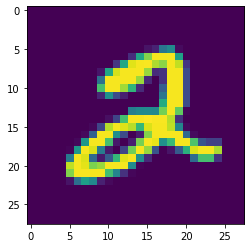

In [10]:
myds.Show(5)

# Create Network

In [69]:
#ds = SimpleDataset(A, B, n=50, noise=0.2)
dl = DataLoader(myds, batch_size=100, shuffle=True)

In [74]:
input_dim = 784
mid_dim = 100
net = PCNetwork.PCNetwork(device=device)
net.AddLayer(PCLayer.PCLayer(n=myds.input_dim, device=device))  # [0] v0 input

net.AddLayer(PCLayer.PCLayer(n=mid_dim, device=device))       # [1] e1 error
net.AddLayer(PCLayer.PCLayer(n=mid_dim, device=device))       # [2] v1 class

net.AddLayer(PCLayer.PCLayer(n=myds.n_classes, device=device))  # [3] e2 error
net.AddLayer(PCLayer.PCLayer(n=myds.n_classes, device=device))  # [4] v2 class

af0 = 'identity'
af = 'tanh'
sym = True
net.Connect(v_idx=0, e_idx=1, type='general', sym=sym, act_text=af0)
net.Connect(e_idx=1, v_idx=2, type='general', sym=True, act_text=af)
net.Connect(v_idx=2, e_idx=3, type='general', sym=sym, act_text=af)
net.Connect(e_idx=3, v_idx=4, type='general', sym=True, act_text=af)

net.SetTau(0.05)

# Training

In [47]:
net.ClearHistory()
net.Probe(False)
net.Learning(True)
net.SetGamma(0.1)
mult = 0.1
l = 0.
h = 1.

net.con[0].SetRandom(random=1./np.sqrt(input_dim)) # e1-v1
net.con[1].SetIdentity()
net.con[2].SetRandom(random=1./np.sqrt(mid_dim)) # v1-e2
net.con[3].SetIdentity()

net.SetDynamicWeightDecay(0.0, 0.8)
net.SetRepelSmallWeights(0.0)
net.SetActivityDecay(0.0)
net.SetBlackout(0.)

In [75]:
net.ClearHistory()
net.Probe(False)
net.Learning(True)
net.SetGamma(0.1)
mult = 0.1
l = 0.
h = 1./10.

net.con[0].SetRandom(random=1./np.sqrt(input_dim)) # e1-v1
#net.con[0].SetRandomUniform(low=l, high=h) # e1-v1
net.con[1].SetRandomUniform(low=l, high=1./mid_dim) # e1-v1
net.con[2].SetRandom(random=1./np.sqrt(mid_dim)) # v1-e2
#net.con[2].SetRandomUniform(low=l, high=h) # v1-e2
net.con[3].SetRandomUniform(low=l, high=h) # e2-v2

net.SetDynamicWeightDecay(0.0, 0.8)
net.SetRepelSmallWeights(0.0)
net.SetActivityDecay(0.0)
net.SetBlackout(0.)

In [85]:
net.Save('mnist.net')

In [86]:
del net

In [87]:
net = PCNetwork.PCNetwork.Load('mnist.net')

In [82]:
net.lyr[0].device

device(type='cuda', index=5)

In [83]:
net.ClearHistory()

In [84]:
net.Learning(True)
net.con[0].Learning(False)
net.con[1].Learning(True)
net.con[2].Learning(False)
net.con[3].Learning(True)
net.SetDynamicWeightDecay(0.01, 0.8)
net.Learn(dl, T=3., epochs=2)

Epoch: 0 weight decay = 0.01
Epoch: 1 weight decay = 0.002


In [89]:
net.Learning(True)
net.con[0].Learning(True)
net.con[1].Learning(False)
net.con[2].Learning(True)
net.con[3].Learning(False)
net.SetDynamicWeightDecay(0.01, 0.8)
net.Learn(dl, T=3., epochs=2)

Epoch: 0 weight decay = 0.01
Epoch: 1 weight decay = 0.002


In [94]:
for c in net.con:
    print(c.WeightNorms())

(tensor(2.8826, device='cuda:5'), tensor(2.8826, device='cuda:5'))
(tensor(3.8284, device='cuda:5'), tensor(3.8284, device='cuda:5'))
(tensor(1.0860, device='cuda:5'), tensor(1.0860, device='cuda:5'))
(tensor(0.9958, device='cuda:5'), tensor(0.9958, device='cuda:5'))


In [96]:
net.Learning(True)
net.con[0].Learning(False)
net.con[1].Learning(True)
net.con[2].Learning(False)
net.con[3].Learning(True)
net.SetDynamicWeightDecay(0.01, 0.8)
net.Learn(dl, T=3., epochs=5)

Epoch: 0 weight decay = 0.01
Epoch: 1 weight decay = 0.002
Epoch: 2 weight decay = 0.00039999999999999986
Epoch: 3 weight decay = 7.999999999999997e-05
Epoch: 4 weight decay = 1.5999999999999992e-05


In [ ]:
net.Learning(True)
net.con[0].Learning(True)
net.con[1].Learning(False)
net.con[2].Learning(True)
net.con[3].Learning(False)
net.SetDynamicWeightDecay(0.01, 0.8)
net.Learn(dl, T=3., epochs=5)

Epoch: 0 weight decay = 0.01


In [93]:
net.Reset()
net.Save('mnist.net')

# Classification

In [95]:
net.Reset(random=1.)
net.Probe(True)
net.SetActivityDecay( 0.0 )
y = net.Predict(myds.Inputs()[:10], T=1.)
print(y[:10])
print(myds.Targets()[:10])

tensor([[ 0.0963,  0.0369,  0.0796,  0.0521,  0.0507,  0.0604,  0.0966,  0.0453,
          0.0429,  0.0459],
        [ 0.1918, -0.0802,  0.0381,  0.0709,  0.0421,  0.0729,  0.0326,  0.1246,
          0.0238,  0.0915],
        [-0.0252,  0.0572,  0.0609,  0.0722,  0.0520,  0.0154,  0.0262,  0.0832,
          0.0306,  0.0797],
        [-0.0351,  0.1791,  0.1121,  0.0427,  0.0265,  0.0371,  0.0921, -0.0404,
          0.0949,  0.0037],
        [ 0.0834,  0.0529,  0.1127,  0.1129,  0.0997,  0.0693,  0.0922,  0.1397,
          0.0769,  0.1326],
        [ 0.1101,  0.0803,  0.1309,  0.1002,  0.0876,  0.0859,  0.1203,  0.1055,
          0.0817,  0.1080],
        [-0.0061,  0.1914,  0.1524,  0.1167,  0.0511,  0.0633,  0.0756,  0.0675,
          0.1048,  0.0884],
        [ 0.0943, -0.0017,  0.0766,  0.1203,  0.0732,  0.0562,  0.0422,  0.1346,
          0.0507,  0.1208],
        [ 0.0074,  0.1549,  0.1266,  0.0716,  0.0524,  0.0549,  0.1035,  0.0234,
          0.0901,  0.0500],
        [ 0.0533,  

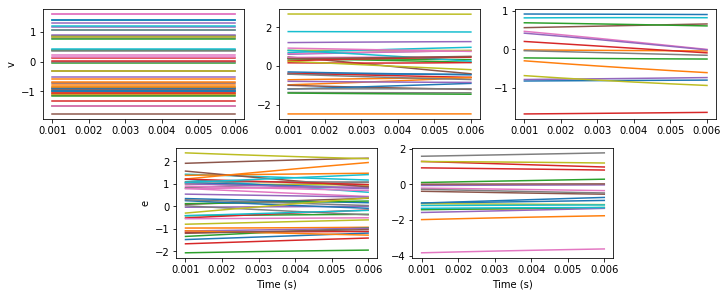

In [28]:
net.Plot(idx=[1,2,3,4,5]);

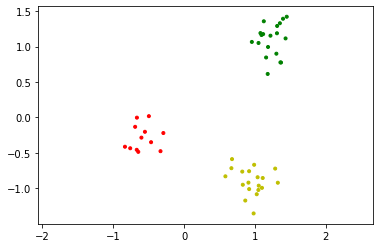

In [772]:
ds.Plot(labels=y, idx=(4,8))

# Generation

In [559]:
net.Reset(random=1.)
net.SetActivityDecay(0.02)
X = net.Generate(ds.Targets(), T=15.)

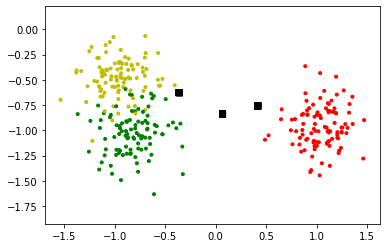

In [560]:
sidx = (0,1)
ds.Plot(idx=sidx)
plt.plot(X[:,sidx[0]], X[:,sidx[1]], 's', color=[0,0,0,0.1]);

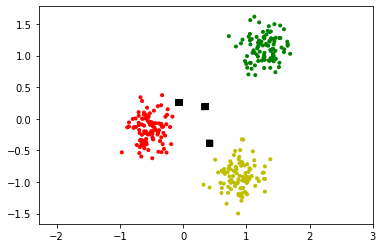

In [561]:
sidx = (4,8)
ds.Plot(idx=sidx)
plt.plot(X[:,sidx[0]], X[:,sidx[1]], 's', color=[0,0,0,0.1]);